In this exercise we will simulate the accumulation of above-ground plant dry biomass of winter wheat using a simple model driven by solar radiation and growing degree days. The model has two routines, one for simulating leaf area index and one for simulating biomass accumulation. This model assumes that there are no environmental limitations other than the input in solar radiation and the changes in air temperature.

The equation modeling the increase in aboveground dry biomass as a function of the intercepted incident solar radiation is:

$$ B_t = B_{t-1} + E_b \; E_{imax} \Bigg[ 1 - e^{-K \; LAI_t} \Bigg] PAR_t$$

The equation modeling the leaf area index as a function of thermal time is:

$$ LAI_t = L_{max} \Bigg[ \frac{1}{1+e^{-\alpha(T_t - T_1)}} -e^{\beta(T_t-T_2)} \Bigg]$$


where parameters are defined by:

$ T_2 = \frac{1}{\beta} log[1 + e^{(\alpha \; T_1)}]$<br>
$B$ is above-ground dry biomass in $g m^{-2}$<br>
$T$ is cumulative growing degree days<br>
$t$ is time in days<br>
$LAI$ is the leaf area index<br>
$L{max}$ is the maximum leaf area index during the entire growing season<br>
$PAR$ is the photosynthetically active radiation<br>
$K$ is the coefficient of extiction<br>
$T_1$ is a growth threshold<br>
$E_b$ is the radiation use efficiency<br>
$E_{imax}$ is the maximal value of intercepted to incident solar radiation<br>
$\alpha$ and $\beta$ are empirical parameters<br>


In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [8]:
# Import data
df = pd.read_csv('../datasets/KS_Manhattan_6_SSW.csv', na_values=[-99, -9999])
df.head(3)


,WBANNO,LST_DATE,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,P_DAILY_CALC,...,SOIL_MOISTURE_5_DAILY,SOIL_MOISTURE_10_DAILY,SOIL_MOISTURE_20_DAILY,SOIL_MOISTURE_50_DAILY,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY
0,53974,20031001,1.201,-96.61,39.1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,53974,20031002,1.201,-96.61,39.1,18.9,2.5,10.7,11.7,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,53974,20031003,1.201,-96.61,39.1,22.6,8.1,15.4,14.8,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Convert LST_DATE to Pandas datetime format
df.insert(2, "DATES", pd.to_datetime(df["LST_DATE"], format="%Y%m%d"))
df.head(3)


,WBANNO,LST_DATE,DATES,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,...,SOIL_MOISTURE_5_DAILY,SOIL_MOISTURE_10_DAILY,SOIL_MOISTURE_20_DAILY,SOIL_MOISTURE_50_DAILY,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY
0,53974,20031001,2003-10-01,1.201,-96.61,39.1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,53974,20031002,2003-10-02,1.201,-96.61,39.1,18.9,2.5,10.7,11.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,53974,20031003,2003-10-03,1.201,-96.61,39.1,22.6,8.1,15.4,14.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Check if average temperature or solar radiation have missing values

print('TAVG:', df["T_DAILY_AVG"].isna().sum())
print('TAVG:', df["T_DAILY_AVG"].isna().sum())

42

In [8]:
# Replace missing values in average air temperature
df["T_DAILY_AVG"].interpolate(method="pchip", inplace=True)


0    11.7
1    11.7
2    14.8
3    14.0
4    17.3
Name: T_DAILY_AVG, dtype: float64

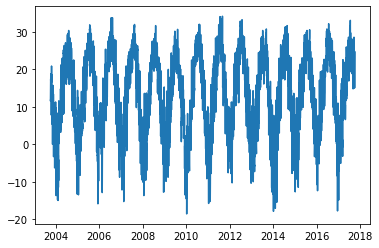

In [9]:
# Let's check our data with a plot
plt.plot(df["DATES"],df["T_DAILY_AVG"])
plt.show()


In [10]:
# Replace missing values in solar radiation
df["SOLARAD_DAILY"].fillna(method="bfill", inplace=True)
df["SOLARAD_DAILY"].head()


0    16.72
1    16.72
2    12.55
3    16.90
4    18.63
Name: SOLARAD_DAILY, dtype: float64

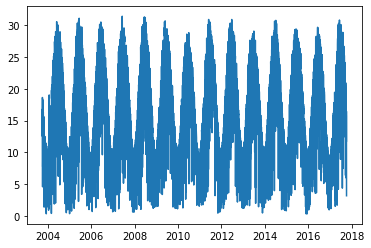

In [11]:
# Plot solar radiation data
plt.plot(df["DATES"],df["SOLARAD_DAILY"])
plt.show()


In [30]:
# Define crop parameters
Tbase = 0
planting_date = "1-Oct-2007"
planting_date = pd.to_datetime(planting_date)
season_length = 250 # days
harvest_date = planting_date + pd.to_timedelta(season_length, unit='days')
TT_max = 2400 # GDD


In [43]:
# Define model parameters
Eb = 1.85
Eimax = 0.94
K = 0.7
Lmax = 7
T1 = 900
alpha = 0.005
beta = 0.002
T2 = 1/beta * np.log(1 + np.exp(alpha*T1))
HI = 0.45 # Approximate harvest index


In [14]:
# Define lambda functions
LAI_fn = lambda x: Lmax*( 1/(1+np.exp(-alpha*(x-T1))) - np.exp(beta*(x-T2)) )
B_fn = lambda LAI,PAR: Eb * Eimax * (1-np.exp(-K*LAI)) * PAR


## Single growing season

For simulating a single crop growing season the easiest approach is to preselect the rows of the historic weather record matching the specified growing season and then iterating over each day. In this particular case we ensure beforehand that the length of the weather records is equal to the growing season.

We will create a new DataFrame with records matching the growing season so that we keep the original DataFrame intact for subsequent simulations.


In [38]:
# Select records for growing season
idx_growing_season = (df["DATES"] >= planting_date) & (df["DATES"] <= harvest_date)
df_growing_season = df.loc[idx_growing_season,:]
df_growing_season.head()

,WBANNO,LST_DATE,DATES,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,...,SOIL_MOISTURE_5_DAILY,SOIL_MOISTURE_10_DAILY,SOIL_MOISTURE_20_DAILY,SOIL_MOISTURE_50_DAILY,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY
1461,53974,20071001,2007-10-01,1.302,-96.61,39.1,28.2,7.1,17.6,18.9,...,-99.0,-99.0,-99.0,-99,-99,NaN,NaN,NaN,NaN,NaN
1462,53974,20071002,2007-10-02,1.302,-96.61,39.1,28.2,9.3,18.7,21.0,...,-99.0,-99.0,-99.0,-99,-99,NaN,NaN,NaN,NaN,NaN
1463,53974,20071003,2007-10-03,1.302,-96.61,39.1,26.6,5.9,16.2,16.3,...,-99.0,-99.0,-99.0,-99,-99,NaN,NaN,NaN,NaN,NaN
1464,53974,20071004,2007-10-04,1.302,-96.61,39.1,31.6,11.6,21.6,23.6,...,-99.0,-99.0,-99.0,-99,-99,NaN,NaN,NaN,NaN,NaN
1465,53974,20071005,2007-10-05,1.302,-96.61,39.1,32.9,21.7,27.3,26.3,...,-99.0,-99.0,-99.0,-99,-99,NaN,NaN,NaN,NaN,NaN


In [41]:
# Initial conditions
TT = np.array([df["T_DAILY_AVG"][0]])
LAI = np.array([0])
B = np.array([0])
DAP = np.array([1])

# Compute growing degree days, leaf area index and biomass.
for i in range(1,df_growing_season.shape[0]):
                   
    # Days after planting counter
    DAP_counter += 1
    DAP = np.append(DAP, DAP_counter)

    # Compute growing degree days
    TT_day = np.maximum(df["T_DAILY_AVG"][i], Tbase);
    TT = np.append(TT, TT[-1] + TT_day)

    # Compute leaf area index
    LAI_day =  np.maximum(LAI_fn(TT[-1]), 0)
    LAI = np.append(LAI, LAI_day)

    # Compute daily biomass
    PAR_day = df["SOLARAD_DAILY"][i] * 0.48
    B_day = B_fn(LAI[-1], PAR_day)

    # Compute cumulative biomass
    B = np.append(B, B[-1] + B_day)


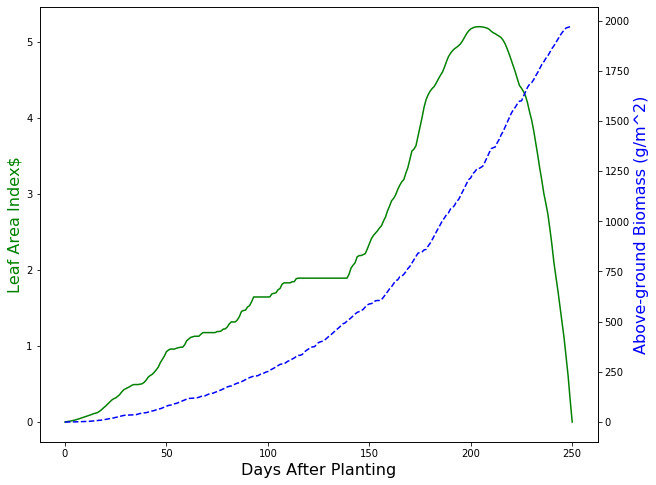

In [42]:
# Generate figure for growing season LAI and Biomass
plt.figure(figsize=(10,8))

# Leaf area index
ax1 = plt.subplot()
ax1.plot(LAI,'-g')

# Biomass
ax2 = ax1.twinx()
ax2.plot(B,'--b')

ax1.set_xlabel('Days After Planting', size=16)
ax1.set_ylabel('Leaf Area Index$', color='g', size=16)
ax2.set_ylabel('Above-ground Biomass (g/m^2)', color='b', size=16)

plt.show()


## Ensemble of multiple growing seasons

Opposite to our previous simulation, here we are interested in modeling as many growing season scenarios as possible given our historical weather dataset.

From the coding perspective, the challenge resides in keeping track of the growing season. This requires that certain conditions are met, such as identifying the beginning of the growing season each year, avoid exceeding the typical growing season length for the specific cultivar both in terms of calendar days and growing degree days, and storing simulation data at the end of each growing season, so that then we can plot the different scenarios.

To keep track and store of multiple variables and growing seasons per variable, dictionaries are probably a good choice. A dictionary is especially versatile in this situation because it can accomodate growing seasons of different lengths. Note that if we set growing season termination rules based on thermal time, some seasons may be shorter than others.




In [44]:
# Initialize dictionary to store data
data = dict()

# Iterate over each weather record
for i in range(df.shape[0]):
    
    if (df["DATES"][i].day == planting_date.day) & (df["DATES"][i].month == planting_date.month):
        
        # If previous condition is met, we are in the growing season
        # Define initial conditions for current growing season (day=1)
        TT = np.array([df["T_DAILY_AVG"][i]])
        LAI = np.array([0])
        B = np.array([0])
        DAP_counter = 1
        DAP = np.array([DAP_counter])
        year_key = df["DATES"][i].year  # Name of dictionary key. Year of planting
            
        # Iterate over days within growing season
        # Program can only proceed with the outer for loop after
        # finishing the current growing season
        while True:

            # Days after planting counter
            i += 1  # Keep track of rows in historic dataset
            DAP_counter += 1
            
            # Break loop if exceeding maximum thermal time or DAP
            if TT[-1] > TT_max | DAP_counter > season_length:
                
                # Compute grain yield in kg/ha using approximate harvest index
                grain_yield = B[-1]*HI*10;
                
                # Store data before braking the loop
                data[year_key] = {"DAP":DAP, "B":B, "LAI":LAI, "grain_yield":grain_yield} 
                break
              
            # Append day after planting counter
            DAP = np.append(DAP, DAP_counter)

            # Compute growing degree days
            TT_day = np.maximum(df["T_DAILY_AVG"][i], Tbase);
            TT = np.append(TT, TT[-1] + TT_day)

            # Compute leaf area index
            LAI_day =  np.maximum( LAI_fn(TT[-1]), 0)
            LAI = np.append(LAI, LAI_day)

            # Compute daily biomass
            PAR_day = df["SOLARAD_DAILY"][i] * 0.48
            B_day = B_fn(LAI[-1], PAR_day)

            # Compute cumulative biomass
            B = np.append(B, B[-1] + B_day)
         
        # Prevent starting an incomplete growing season
        if i + season_length > df.index[-1]:
            break


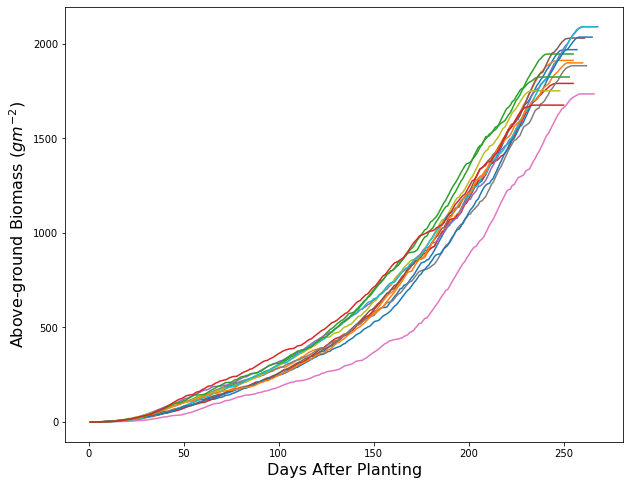

In [29]:
# Plot biomass scenarios
plt.figure(figsize=(10,8))
for key in data.keys():
    plt.plot(data[key]["DAP"], data[key]["B"])
    
plt.xlabel('Days After Planting', size=16)
plt.ylabel('Above-ground Biomass ($g m^{-2}$)', size=16)
plt.show()

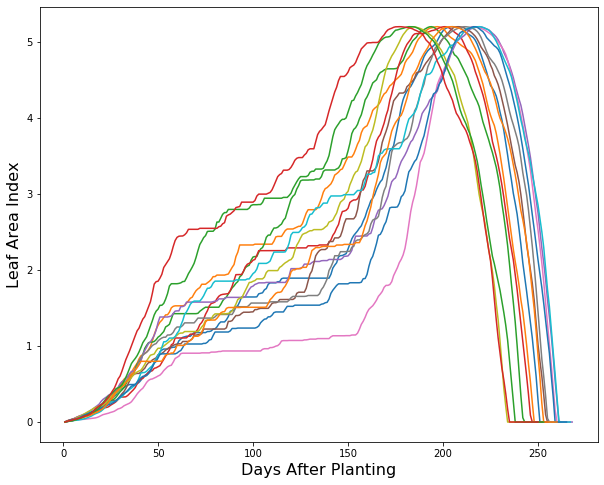

In [28]:
# Plot leaf area index scenarios
plt.figure(figsize=(10,8))
for key in data.keys():
    plt.plot(data[key]["DAP"], data[key]["LAI"])
    
plt.xlabel('Days After Planting', size=16)
plt.ylabel('Leaf Area Index', size=16)
plt.show()

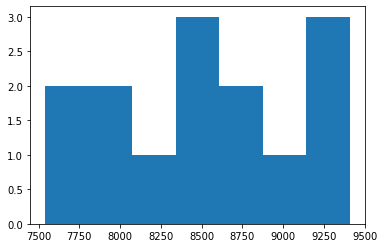

In [56]:
# Plot histogram of grain yield scenarios
all_yield = []
for key in data.keys():
    all_yield = np.append(all_yield, data[key]["grain_yield"])
    
plt.hist(all_yield, bins=7)
plt.show()

## References

Brun, F., Wallach, D., Makowski, D. and Jones, J.W., 2006. Working with dynamic crop models: evaluation, analysis, parameterization, and applications. Elsevier.